# Cornell Course Classification and South Asian Representation

Authored by Katie Huntley (kah294)

Decemeber 16, 2024



This notebook presents all code used in data collection and analysis.
For full commentary and data interpretation please refer to the report linked [here](https://drive.google.com/file/d/1XR8viWzqrRvNW9Dnb-7IqarWUTinn0Zm/view?usp=sharing).

# Imports

In [ ]:
import requests
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import numpy as np
from typing import Dict
from sentence_transformers import SentenceTransformer
from collections import Counter
import matplotlib.pyplot as plt
from scipy.stats import linregress
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForSeq2SeqLM, AutoTokenizer, AutoModel, pipeline
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import f1_score, precision_score, recall_score
import os

# Dataset Collection

In [ ]:
API_BASE_URL = "https://classes.cornell.edu/api/2.0"
HUMANITIES_DEPTS = ['AAS','AIIS','AMST','ANTHR','ARAB','ARKEO','ART','ARTH','ASIAN','ASL','ASRC','CLASS','COML','COMM','ENGL','FGSS','GERST','HIST','JWST','LATA','LING','MEDVL','MUSIC','PHIL','RELST','ROMS','SOC','SPAN','STS','VISST','WRIT']
SCHOOLYEARS = {'FA21': '2021/22', 'SP22': '2021/22', 'FA22': '2022/23', 'SP23':'2022/23', 'FA23':'2023/24', 'SP24':'2023/24', 'FA24':'2024/25', 'SP25':'2024/25'}

In [ ]:
def clean_df(df):
  """
  This function takes the following steps to clean the input courses dataframe:
    - Removes "FWS: " from course titles
    - Removes classes with little to no description
    - Removes duplicate classes from crosslisting
    - Removes non-informative classes involving honors/thesis work, independent study

  Output is the modified dataframe.
  """

  # Remove "FWS: " from course titles
  df['title'] = df['title'].str.replace(r'^FWS: ', '', regex=True)
  df['title'] = df['title'].str.replace(r'^FWS:', '', regex=True)

  # Remove classes with little to no description
  df = df[df['description'].str.len() >= 50]
  print("Samples after removing short descriptions:", df.shape[0])

  # Remove duplicate classes from crosslisting
  df = df.drop_duplicates(subset=['title', 'semester'])
  print("Samples after removing duplicated, crosslisted courses", df.shape[0])

  # Remove non-informative classes involving honors/thesis work, independent study
  df = df[~df['title'].str.contains('Independent|Honors|Thesis', case=False, na=False)]
  print("Samples after removing honors/thesis work, independent study courses", df.shape[0])

  return df

In [ ]:
def assemble_dataset(semesters):
  """
  This function takes a list of semesters as input to fetch data from the Cornell University course roster API.
  The output is a pandas dataframe with the following columns: title, description, schoolyear, semester.
  Each entry in the resulting dataframe represents one course.
  """

  titles = []
  descriptions = []
  schoolyears = []
  df_semesters = []

  for semester in semesters:
      for dept in HUMANITIES_DEPTS:
          response = requests.get(
              f"{API_BASE_URL}/search/classes.json",
              params={"roster": semester, "subject": dept}
          )
          json = response.json()
          if json['status'] == 'success':
            courses = json['data']['classes']
            for course in courses:
                df_semesters += [semester]
                titles += [course['titleLong']]
                descriptions += [course['description']]
                schoolyears += [SCHOOLYEARS[semester]]

  df = pd.DataFrame()
  df['title'] = titles
  df['description'] = descriptions
  df['schoolyear'] = schoolyears
  df['semester'] = df_semesters
  print(f"Samples before any processing: {df.shape[0]}")
  df = clean_df(df)
  df['content'] = df['title'] + '\n' + df['description']
  return df

In [ ]:
SEMESTERS = ['FA21', 'SP22', 'FA22', 'SP23', 'FA23', 'SP24', 'FA24', 'SP25']
courses_df = assemble_dataset(SEMESTERS)

Samples before any processing: 8239
Samples after removing short descriptions: 8001
Samples after removing duplicated, crosslisted courses 4804
Samples after removing honors/thesis work, independent study courses 4451


# Zero-Shot Predictions

In [ ]:
def predict_on_labels(df, model, labels, batch_size=16):
  """
  This function uses the given model to make predictions on each entry in the provided courses dataframe.
  Each course is assigned one of the labels in the provided labels list.

  The output is a new dataframe with the following columns: content, binary label, predicted label, schoolyear
  The binary label consists of 1s and 0s where 1s indicate that the course was assigned one of the first n-1 labels in the provided labels list.
  """

  pos_labels = labels[:len(labels)-1]
  texts = df['content'].tolist()

  # Batch size for processing
  num_batches = int(np.ceil(len(texts) / batch_size))  # Calculate number of batches

  # Store results
  predicted_labels = []

  # Process texts in batches
  for i in range(num_batches):
      batch_texts = texts[i * batch_size : (i + 1) * batch_size]  # Create batch slice
      results = model(batch_texts, labels)  # Process batch

      # Extract predicted labels for each text in the batch
      for result in results:
          predicted_labels.append(result['labels'][0])

  return_df = pd.DataFrame()
  return_df['content'] = df['content']

  binary_labels = [1 if label in pos_labels else 0 for label in predicted_labels]
  return_df['binary label'] = binary_labels
  return_df['predicted label'] = predicted_labels

  return_df['schoolyear'] = df['schoolyear']
  return return_df

In [ ]:
def plot_labels(df, plot_title):
  """
  This function plots predicted South Asian courses per school year as a bar chart.
  The plot is overlaid with a line of best fit.

  The input dataframe must have the following columns: binary label, schoolyear.
  """

  # Group by school year and predicted label, counting occurrences
  count_pos_labels_per_year = df[df['binary label'] == 1].groupby('schoolyear').size()
  print((count_pos_labels_per_year))

  # Plotting bar chart
  plt.figure(figsize=(10, 6))
  plt.bar(count_pos_labels_per_year.index, count_pos_labels_per_year.values, label='South Asian Counts', color='lightblue')

  # Adding titles and labels
  plt.title(plot_title)
  plt.xlabel('School Year')
  plt.ylabel('South Asian Course Count')
  plt.xticks(rotation=0)  # Rotate x-axis labels to make them readable

  # Line of best fit
  x = np.arange(len(count_pos_labels_per_year))  # X values (school years)
  y = count_pos_labels_per_year.values  # Y values (counts)
  slope, intercept, r_value, p_value, std_err = linregress(x, y)  # Perform linear regression

  # Plotting the line of best fit
  plt.plot(count_pos_labels_per_year.index, slope * x + intercept, color='red', label='Line of Best Fit', linestyle='--')

  # Display the legend
  plt.legend()

  # Save the plot
  plt.savefig(f"{plot_title}.png")

  # Show the plot
  plt.show()

In [ ]:
def sample_labels(df):
  """
  This function picks 5 positively labeled and 5 negatively labeled courses at random and prints the course title and description.

  The input dataframe must have the following columns: content, binary label.
  """

  sample_pos_courses = df[df['binary label'] == 1].sample(n=5)
  print(f"Random Positive Courses:")
  for sample in sample_pos_courses['content']:
      print(sample)
      print()

  sample_neg_courses = df[df['binary label'] == 0].sample(n=5)
  print(f"Random Negative Courses:")
  for sample in sample_neg_courses['content']:
      print(sample)
      print()

In [ ]:
model = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
save_path = "/content/all_predictions.csv"

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
if os.path.exists(save_path):
  print(f"Loading existing data at {save_path}")
  all_predictions_df = pd.read_csv(save_path)
  print(all_predictions_df.head())
else:
  print(f"No existing predictions found at {save_path}")
  print("Creating new dataframe from scratch")
  all_predictions_df = pd.DataFrame()
  all_predictions_df['content'] = courses_df['content']
  all_predictions_df['schoolyear'] = courses_df['schoolyear']

Loading existing data at /content/all_predictions.csv
                                             content schoolyear  \
0  Death in the City: Funerary Architecture in Mu...    2021/22   
1  Mahayana Buddhism\nThis course will explore th...    2021/22   
2  The Great Epic of India\nThe great Sanskrit ep...    2022/23   
3  Mughal India and the Early Modern World, c. 15...    2022/23   
4  Scandal, Corruption, and the Making of the Bri...    2022/23   

   trial 1 label  trial 2 label  trial 3 label  trial 4 label  trial 5 label  \
0              1              1              1              1              1   
1              1              1              1              1              1   
2              1              1              1              1              1   
3              1              1              1              1              1   
4              1              1              1              1              1   

   gold standard  
0              1  
1              1  
2    

In [ ]:
def make_trial_df(labels, trial_number, comprehensive_df):
  if f'trial {trial_number} label' in comprehensive_df.columns:
    trial_df = pd.DataFrame()
    trial_df['content'] = comprehensive_df['content']
    trial_df['binary label'] = comprehensive_df[f'trial {trial_number} label']
    trial_df['schoolyear'] = comprehensive_df['schoolyear']
  else:
    print(f"No existing predictions found for trial {trial_number}")
    print("Beginning to predict with model")
    trial_df = predict_on_labels(courses_df, model, trial_one_labels)
    comprehensive_df[f'trial {trial_number} label'] = trial_df['binary label']
    print(f"Saving trial {trial_number} predictions to {save_path}")
    comprehensive_df.to_csv(save_path, index=False)

  return trial_df

In [ ]:
trial_one_labels = ["South Asian", "not South Asian"]
trial_one_df = make_trial_df(trial_one_labels, 1, all_predictions_df)

schoolyear
2021/22    50
2022/23    52
2023/24    39
2024/25    42
dtype: int64


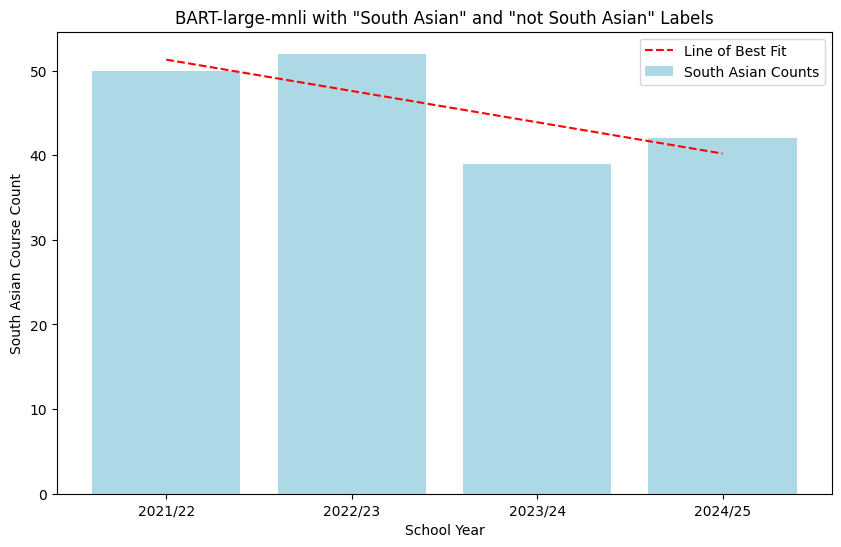

In [ ]:
plot_labels(trial_one_df, "BART-large-mnli with \"South Asian\" and \"not South Asian\" Labels")

In [ ]:
sample_labels(trial_one_df)

Random Positive Courses:
South Asia: Readings in Special Problems
Independent reading course in topics not covered in regularly scheduled courses. Students select a topic in consultation with the faculty member who has agreed to supervise the course work.

Economic Sociology of Social Inequalities
This seminar explores the causes and consequences of social inequalities embedded in economic institutions and markets. From hierarchies to markets, stratification is embedded in networks and norms that enable and guide economic action. As such, the mechanisms of social inequalities involve processes that are hidden in everyday social interactions. The economic sociology of social inequalities encompasses systems of class power, ethnic and racial stratification, and gender inequalities. We will use a case study method to explore and dissect the economic sources of social inequalities in everyday life.

South Asia: Readings in Special Problems
Independent reading course in topics not covered i

In [ ]:
trial_two_labels = ["South Asian topics", "miscellaneous topics"]
trial_two_df = make_trial_df(trial_two_labels, 2, all_predictions_df)

schoolyear
2021/22    78
2022/23    93
2023/24    68
2024/25    80
dtype: int64


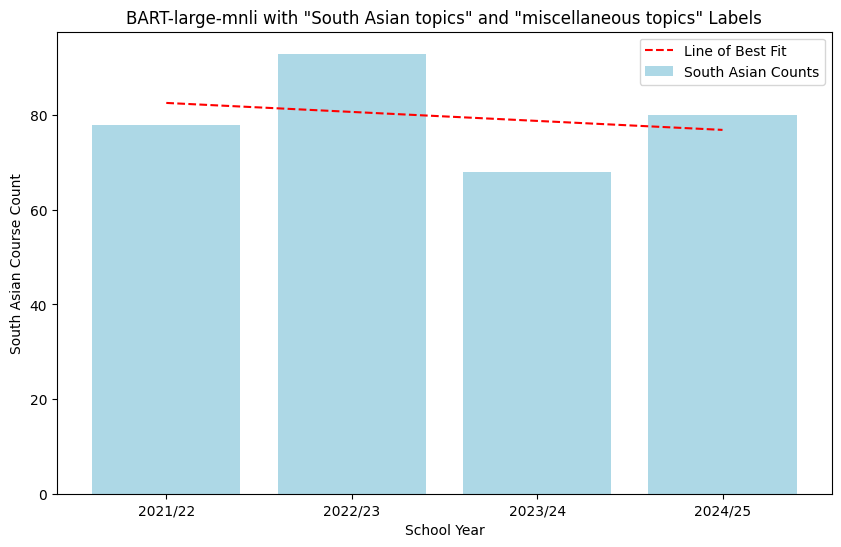

In [ ]:
plot_labels(trial_two_df, "BART-large-mnli with \"South Asian topics\" and \"miscellaneous topics\" Labels")

In [ ]:
sample_labels(trial_two_df)

Random Positive Courses:
Introduction to Indian Philosophy
This course will survey the rich and sophisticated tradition of Indian philosophical thought from its beginnings in the speculations of Upanishads, surveying debates between Hindus, Buddhists, Jains and materialistic philosophers about the existence and nature of God and of the human soul, the nature of knowledge, and the theory of language.

Mahayana Buddhism
This course will explore the origins and early developments of a movement in Indian Buddhism known as the Great Vehicle. We will intensively examine a small slice of this movement's voluminous literature so as to better understand its call for a new spiritual orientation within Buddhism. Topics of discussion will include the career of the bodhisattva, the lay/monk distinction, attitudes of Mahayanists toward women and other Buddhists, and the development of Buddhist utopias and transcendent buddhas. 

Kingship and Statecraft in Asia: Angkor and Beyond
Kingship plays an ou

In [ ]:
trial_three_labels = ["South Asian topics", "miscellaneous topics"]
trial_three_df = make_trial_df(trial_three_labels, 3, all_predictions_df)

schoolyear
2021/22    33
2022/23    32
2023/24    29
2024/25    28
dtype: int64


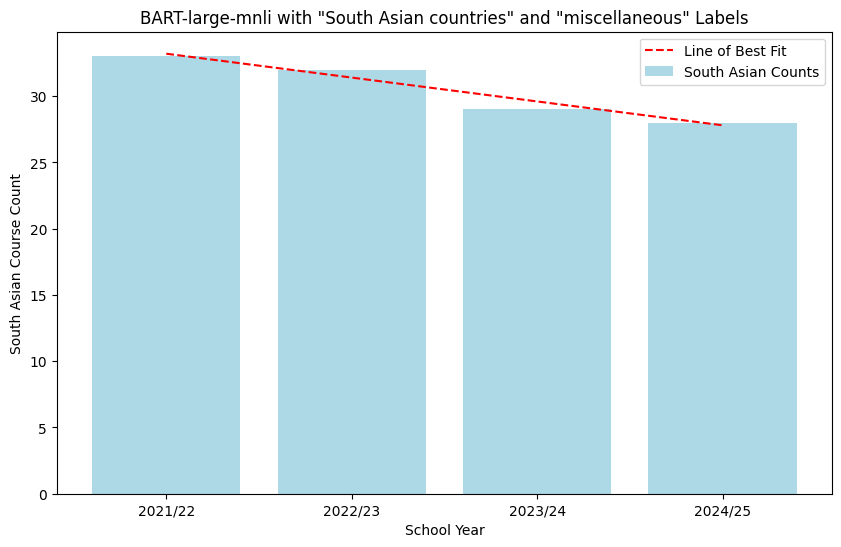

In [ ]:
plot_labels(trial_three_df, "BART-large-mnli with \"South Asian countries\" and \"miscellaneous\" Labels")

In [ ]:
sample_labels(trial_three_df)

Random Positive Courses:
Introduction to Linguistics
Overview of the science of language, especially its theoretical underpinnings, methods, and major findings. Areas covered include: the relation between sound and meaning in human languages, social variation in language, language change over time, universals of language, and the mental representation of linguistic knowledge. Students are introduced to a wide variety of language phenomena, drawn not only from languages resembling English, but also from many that appear to be quite unlike English, such as those native to the Americas, Africa, Asia, Australia, and the South Pacific.

Introduction to Indian Philosophy
This course will survey the rich and sophisticated tradition of Indian philosophical thought from its beginnings in the speculations of Upanishads, surveying debates between Hindus, Buddhists, Jains and materialistic philosophers about the existence and nature of God and of the human soul, the nature of knowledge, and the th

In [ ]:
trial_four_labels = ["Afghanistan", "Bangladesh", "Bhutan", "India", "Maldives", "Nepal", "Pakistan",  "Sri Lanka", "other"]
trial_four_df = make_trial_df(trial_four_labels, 4, all_predictions_df)

schoolyear
2021/22    23
2022/23    35
2023/24    23
2024/25    32
dtype: int64


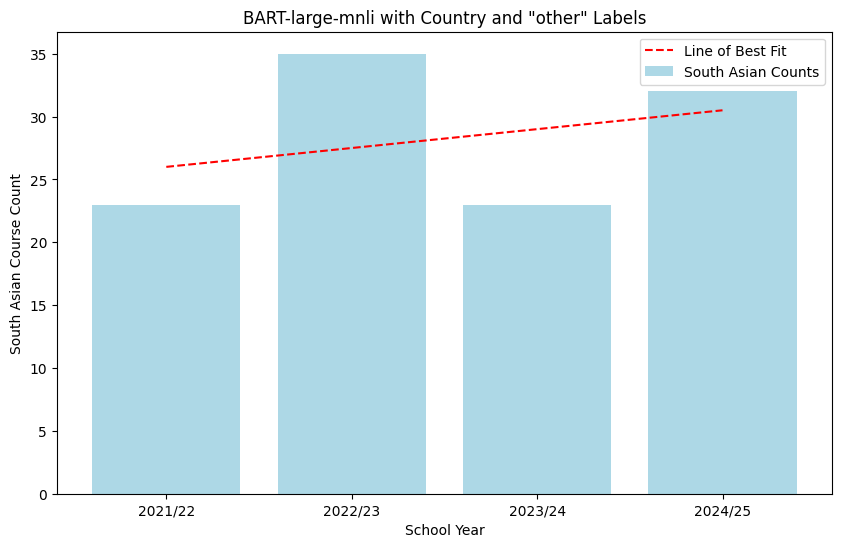

In [ ]:
plot_labels(trial_four_df, "BART-large-mnli with Country and \"other\" Labels")

In [ ]:
sample_labels(trial_four_df)

Random Positive Courses:
Poetry of Classical India
The course will survey in translation a selection of major works of poetry, drama, and aesthetic theory and criticism from the Sanskrit literary tradition of ancient India. Beginning with selections from the Sanskrit epic Ramayana, traditionally regarded as the "first poem" in the Indian tradition, we will turn tosurvey prominent examples from the ongoing tradition of epic poetry, the rise of romantic and heroic drama through the works of the fifth century Gupta poet Kalidasa and his successors, and the extensive corpus of Sanskrit and Prakrit lyric poetry from the 2nd to the 12th century AD.

Directed Research Experience
Intended for freshmen and sophomore students who are new to undergraduate research. Students may be reading scientific literature, learning research techniques, or assisting with ongoing research. The faculty supervisor determines the work goals and the form of the final report.

Writing History
How can we learn about

In [ ]:
trial_five_labels = ["Afghan", "Bangladeshi", "Bhutanese", "Indian", "Maldivian", "Nepalese", "Pakistani", "Sri Lankan", "other"]
trial_five_df = make_trial_df(trial_five_labels, 5, all_predictions_df)

schoolyear
2021/22    7
2022/23    7
2023/24    4
2024/25    7
dtype: int64


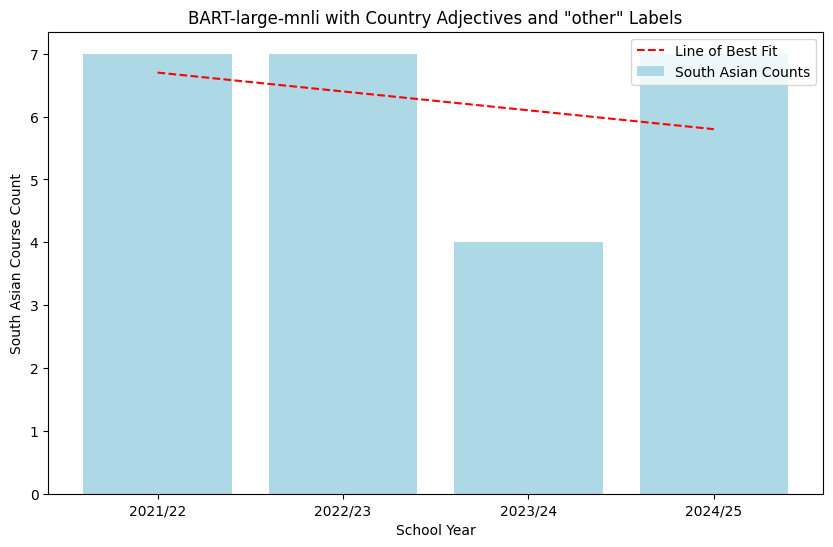

In [ ]:
plot_labels(trial_five_df, "BART-large-mnli with Country Adjectives and \"other\" Labels")

In [ ]:
sample_labels(trial_five_df)

Random Positive Courses:
History of Modern India
This introductory course is a broad survey of the history of the Indian subcontinent from remnants of the Mughal empire through the end of the British empire into the postcolonial present. Prominent themes include the emergence of nonviolent protest, religious and regional identities, ethnic rivalries, social reform and the "woman question," deindustrialization, nationalism and the place of democracy and militarism in a region that includes two nuclear powers, India and Pakistan. 

Death in the City: Funerary Architecture in Muslim South Asia
This seminar examines the development and transformation of Muslim funerary landscapes in the Indian subcontinent from the twelfth to the nineteenth centuries. It explores the relationship between sepulchral spaces and the urban environments with which they are connected, highlighting their role as spaces of sociability as well as piety. We will study the long history of funerary architecture throug

# Gold Standard

Gold standard found
schoolyear
2021/22    24
2022/23    22
2023/24    16
2024/25    22
dtype: int64


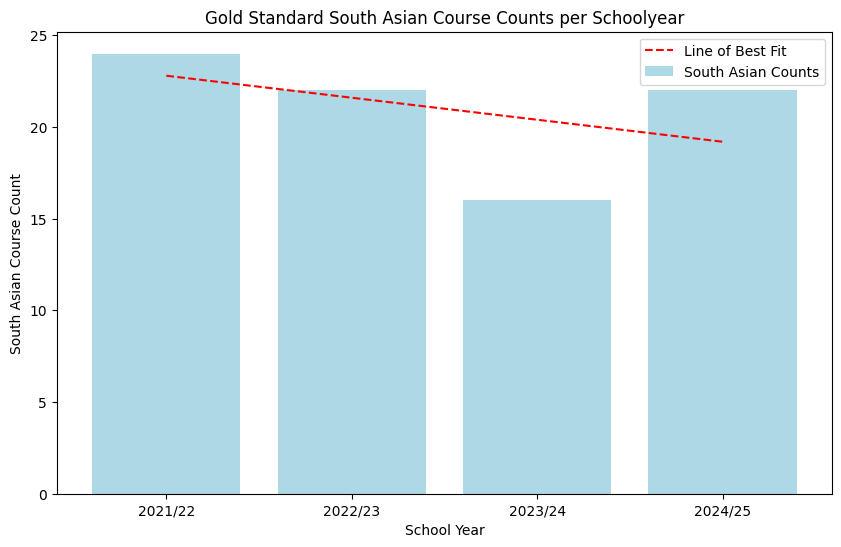

In [ ]:
if 'gold standard' in all_predictions_df.columns:
    print("Gold standard found")

    count_pos_labels_per_year = all_predictions_df[all_predictions_df['gold standard'] == 1].groupby('schoolyear').size()
    print((count_pos_labels_per_year))

    # Plotting bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(count_pos_labels_per_year.index, count_pos_labels_per_year.values, label='South Asian Counts', color='lightblue')

    # Adding titles and labels
    plt.title("Gold Standard South Asian Course Counts per Schoolyear")
    plt.xlabel('School Year')
    plt.ylabel('South Asian Course Count')
    plt.xticks(rotation=0)  # Rotate x-axis labels to make them readable

    # Line of best fit
    x = np.arange(len(count_pos_labels_per_year))  # X values (school years)
    y = count_pos_labels_per_year.values  # Y values (counts)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)  # Perform linear regression

    # Plotting the line of best fit
    plt.plot(count_pos_labels_per_year.index, slope * x + intercept, color='red', label='Line of Best Fit', linestyle='--')

    # Display the legend
    plt.legend()

    # Save the plot
    plt.savefig("gold_standard_graph.png")

    # Show the plot
    plt.show()

else:
    print("Gold standard not found")

# Trial Comparison

In [ ]:
trial_agreement_df = pd.DataFrame()

agreement_data = []
for i in range(1, 6):
    agreement = [f'trial {i}']
    for j in range(1, 6):
        kappa = cohen_kappa_score(all_predictions_df[f'trial {i} label'], all_predictions_df[f'trial {j} label'])
        agreement.append(kappa)
    agreement_data.append(agreement)

trial_agreement_df = pd.DataFrame(agreement_data, columns=['Trial'] + [f'trial {j}' for j in range(1, 6)])

print(trial_agreement_df)


     Trial   trial 1   trial 2   trial 3   trial 4   trial 5
0  trial 1  1.000000  0.377811  0.393131  0.058242  0.067699
1  trial 2  0.377811  1.000000  0.463982  0.138977  0.095215
2  trial 3  0.393131  0.463982  1.000000  0.156463  0.182849
3  trial 4  0.058242  0.138977  0.156463  1.000000  0.224745
4  trial 5  0.067699  0.095215  0.182849  0.224745  1.000000


In [ ]:
if 'gold standard' in all_predictions_df.columns:
    print("Gold standard found")
    print("Beginning precision, recall, and f1 score calculation")
    print()

    trial_stats = []
    for i in range(1, 6):
        precision = precision_score(all_predictions_df['gold standard'], all_predictions_df[f'trial {i} label'], average='binary')
        recall = recall_score(all_predictions_df['gold standard'], all_predictions_df[f'trial {i} label'], average='binary')
        f1 = f1_score(all_predictions_df['gold standard'], all_predictions_df[f'trial {i} label'], average='binary')
        trial_stats.append([f'Trial {i}', precision, recall, f1])

    trial_stats_df = pd.DataFrame(trial_stats, columns=['Trial', 'Precision', 'Recall', 'F1'])
    print(trial_stats_df)
else:
    print("Gold standard not found")


Gold standard found
Beginning precision, recall, and f1 score calculation

     Trial  Precision    Recall        F1
0  Trial 1   0.322404  0.702381  0.441948
1  Trial 2   0.260188  0.988095  0.411911
2  Trial 3   0.418033  0.607143  0.495146
3  Trial 4   0.203540  0.273810  0.233503
4  Trial 5   0.640000  0.190476  0.293578
